In [111]:
# main code that defines the functions
import math
import numpy as np
from scipy.interpolate import interp1d

# Define a small tolerance for numerical comparisons.
TOL = 1e-12

def runge_kutta_step(x, y, yp, h, e, l, ww, potential):
    """
    Perform one RK4 step for the ODE y'' = (V_eff(x)-e)*y.
    V_eff(x) = ww * potential(x) + (l(l+1))/x^2   (if l>=1)
             = ww * potential(x)                    (if l<1)
    """
# ww = 2*m1*m2/(m1+m2)  
    def diffl(x_val, e_val):
        # effective potential term (add angular momentum only if l>=1)
        if l >= 1:
            return ww * potential(x_val) + l * (l + 1) / (x_val ** 2) - e_val
        else:
            return ww * potential(x_val) - e_val

    a1 = yp * h
    b1 = diffl(x, e) * h * y

    a2 = (yp + b1 / 2) * h
    x_mid = x + h / 2
    # Note: we use diffl(x_mid, e) here.
    b2 = diffl(x_mid, e) * h * (y + a1 / 2)

    a3 = (yp + b2 / 2) * h
    b3 = diffl(x_mid, e) * h * (y + a2 / 2)

    a4 = (yp + b3 / 2) * h
    x_new = x + h
    b4 = diffl(x_new, e) * h * (y + a3)

    y_new = y + (a1 + 2 * a2 + 2 * a3 + a4) / 6
    yp_new = yp + (b1 + 2 * b2 + 2 * b3 + b4) / 6
    return x_new, y_new, yp_new

def xwmil1(l, h, wei, xrat, ww, potential):
    """
    Find the matching point xwmin.
    For l>=1, V_eff includes the centrifugal term.
    For l<1, only the potential is used.
    
    Parameters:
      l     : orbital angular momentum quantum number
      h     : integration step
      wei   : step for finding xwmin
      xrat  : initial guess (should be > h/10)
      ww    : parameter (reduced mass factor)
      potential : a callable function potential(x)
      
    Returns:
      xwmin: the matching point
    """
    del_x = h / 10
    xs = xrat
    if xs < del_x:
        raise ValueError("xrat is too small; must be at least h/10.")
        
    # If l < 1, use the version without the angular momentum term.
    use_l_term = (l >= 1)
    
    # We iterate until we find a point where the effective potential's curvature
    # is “flat enough” (i.e. where the left and right differences nearly agree).
    while True:
        if xs < wei + del_x:
            xs = del_x
            break
        # Define the effective potential:
        if use_l_term:
            ms = ww * potential(xs) + l * (l + 1) / (xs ** 2)
            rs = ww * potential(xs + wei) + l * (l + 1) / ((xs + wei) ** 2)
            ls = ww * potential(xs - wei) + l * (l + 1) / ((xs - wei) ** 2)
        else:
            ms = ww * potential(xs)
            rs = ww * potential(xs + wei)
            ls = ww * potential(xs - wei)
        
        if rs > ms and ms > ls:
            xs = xs - wei
            continue
        if rs < ms and ls > ms:
            xs = xs + wei
            continue
        if abs(rs - ls) < TOL:
            break
        if rs > ms and ls > ms:
            if wei < h:
                break
            else:
                wei = wei / 10
                continue
        # If none of the conditions are met, something is off.
        raise RuntimeError("SOMETHING IS WRONG, ANALYZE POTENTIAL in xwmil1!")
        
    # xs now is taken as xwmin (later shifted by h in schroe)
    return xs

def schroe(el, eu, n0, l, h, m1, m2, potential):
    """
    Solve the radial Schrödinger equation with a shooting/bisection method.
    
    The ODE is:
      y''(x) = [ ww * V(x) + l(l+1)/x^2 - e ] * y(x)
    with the initial conditions at x = del_x = h/10:
      y(del_x) = del_x^(l+1)   and   y'(del_x) = (l+1)*del_x^l.
      
    Parameters:
      el, eu   : initial lower and upper bounds for the energy (before scaling)
      n0       : desired number of nodes (nodeless state: n0=0)
      l        : orbital angular momentum quantum number
      h        : integration step size
      m1, m2   : masses used to compute the reduced mass parameter: ww = 2*m1*m2/(m1+m2)
      potential: a callable function potential(x)
      
    Returns:
      eigenvalue : the computed eigenvalue (divided by ww as in the original code)
      x_data, y_data : lists with the x–values and wavefunction values (the reduced radial function)
      xmax     : maximum x reached in the integration
    """
    # Compute the reduced mass factor:
    ww = 2 * m1 * m2 / (m1 + m2)
    
    # First, determine the “matching point” xwmin.
    # (The original code calls xwmil1 with wei=0.05 and xrat=2.)
    xwmin = xwmil1(l, h, wei=0.05, xrat=2, ww=ww, potential=potential)
    xwmin = xwmin + h  # as in the original code
    
    del_x = h / 10
    feh = 0.00000005 * ww   # prescribed error
    
    # Define the effective potential function (without the energy shift)
    def diffl(x_val, e_val):
        if l >= 1:
            return ww * potential(x_val) + l * (l + 1) / (x_val ** 2) - e_val
        else:
            return ww * potential(x_val) - e_val

    # Bisection loop (label 300 in the original code)
    while (eu - el) >= feh:
        eps = (el + eu) / 2  # trial energy
        
        # Initialize integration (starting at x=del_x)
        x = del_x
        # Even if l==0, we use y = x^(l+1); note: for l=0, y=x.
        y = x ** (l + 1)
        yp = (l + 1) * (x ** l)
        yold = y  # to check for sign changes
        n0x = 0  # node count
        
        # Begin integration using RK4 until we reach the turning point.
        while True:
            x, y, yp = runge_kutta_step(x, y, yp, h, eps, l, ww, potential)
            
            # Count nodes (sign changes of y)
            if y * yold < 0:
                n0x += 1
            yold = y
            
            # Calculate the local value u2 = diffl(x, eps)
            u2 = diffl(x, eps)
            
            # Continue integration if we are still before the classical turning point.
            # (i.e. if u2 is negative or x is not yet beyond xwmin)
            if (u2 < 0 or x < xwmin):
                continue
            
            # Also, if the product y*yp is negative (indicating oscillatory behavior), continue.
            if (y * yp < 0):
                continue
            
            # Otherwise, we have reached a point where the solution diverges.
            break
        
        # Adjust the energy bounds:
        if n0x > n0:
            # Too many nodes – lower energy is too high; update the upper bound.
            eu = eps
        else:
            # Too few nodes – energy is too low; update the lower bound.
            el = eps
        # Loop again until (eu-el) < feh.
    
    # At this point, eps is our computed eigenvalue.
    eigenvalue = eps / ww  # as in the original code

    # Now do a final integration to record the wavefunction.
    ep = eps
    j = 0
    x_data = []
    y_data = []
    
    x = del_x
    y = x ** (l + 1)
    yp = (l + 1) * (x ** l)
    yold = y
    n0x = 0

    # Integrate until we pass the turning point.
    while True:
        j += 1
        x_data.append(x)
        y_data.append(y)
        
        x, y, yp = runge_kutta_step(x, y, yp, h, ep, l, ww, potential)
        
        if y * yold < 0:
            n0x += 1
            if n0x > n0:
                # Once we have passed the desired number of nodes, we stop.
                break
        yold = y
        
        # When we have passed the turning point, and the product y*yp is positive,
        # we assume that the wavefunction is diverging and end the integration.
        u2 = diffl(x, ep)
        if not (u2 < 0 or x < xwmin):
            if y * yp >= 0:
                break

    xmax = x_data[-1]
    
    # (Optionally, one could build an interpolation function here:)
    #yschr_interp = interp1d(x_data, y_data, kind='cubic', fill_value="extrapolate")
    
    return eigenvalue, x_data, y_data, xmax

Eigenvalue for n=0: -0.4999999702
Eigenvalue for n=1: -0.1250515282
Eigenvalue for n=2: -0.0555708110


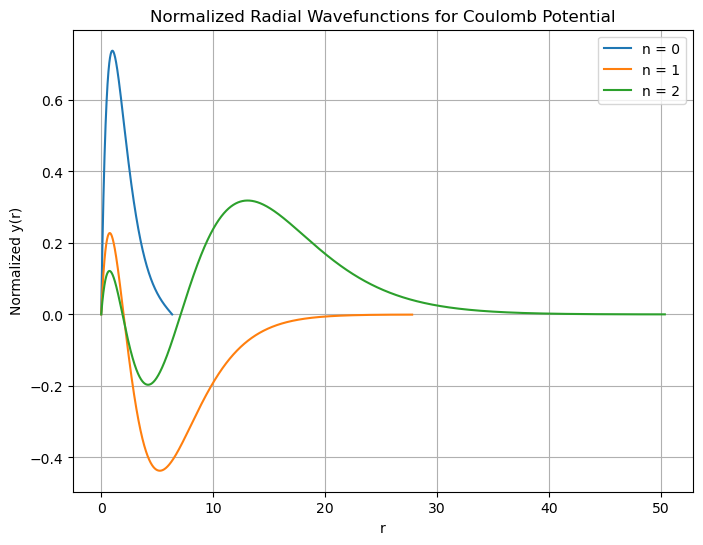

In [113]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Define the Coulomb potential V(r) = -1/r.
def coulomb_potential(r):
    return -1.0/r if r>0 else -1e6

# --- Normalization helper
def normalize(x, y):
    """
    Normalize wavefunction y(x) so that ∫₀^∞ [y(x)]² dx = 1.
    Uses the composite trapezoidal rule.
    """
    x_arr = np.array(x)
    y_arr = np.array(y)
    norm = np.sqrt(np.trapz(y_arr**2, x_arr))
    return y_arr / norm

# --- Simulation parameters (user inputs)
el = -1.0      # initial lower bound for energy
eu = 0.0       # initial upper bound for energy
l  = 0.0         # orbital angular momentum (0 for s-wave)
h  = 0.005      # integration step size
m1 = 2.0       # mass 1
m2 = 2.0       # mass 2
max_states = 3 # number of bound states to compute

# --- Arrays to hold results
energies = []
wavefunctions = []

# --- Loop over desired states n0 = 0, 1, 2, ...
for n0 in range(max_states):
    eigenvalue, x_vals, y_vals, xmax = schroe(
        el, eu, n0, l, h, m1, m2, coulomb_potential
    )
    energies.append(eigenvalue)
    
    # Normalize the raw wavefunction y_vals → y_norm
    y_norm = normalize(x_vals, y_vals)
    wavefunctions.append((x_vals, y_norm))
    
    print(f"Eigenvalue for n={n0}: {eigenvalue:.10f}")

# --- Plot all normalized wavefunctions
plt.figure(figsize=(8, 6))
for n0, (x, y) in enumerate(wavefunctions):
    plt.plot(x, y, label=f"n = {n0}")
plt.xlabel("r")
plt.ylabel("Normalized y(r)")
plt.title("Normalized Radial Wavefunctions for Coulomb Potential")
plt.legend()
plt.grid(True)
plt.show()
# theoretical values En=-0.5/n^2 (Hartree)  n= number of nodes +1

Using harmonic oscillator potential: V(r) = 0.5 r^2
Eigenvalue for n = 0: 1.4999530837
Eigenvalue for n = 1: 3.4999298677
Eigenvalue for n = 2: 5.4999128357
Eigenvalue for n = 3: 7.4998990074
Eigenvalue for n = 4: 9.4998872653


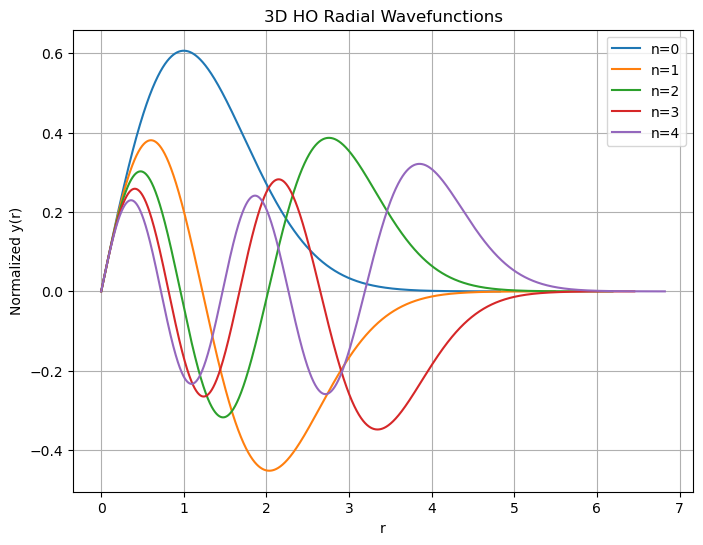

In [115]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Put your V(r) here
def potential(r):
    return 0.5 * r**2

print("Using harmonic oscillator potential: V(r) = 0.5 r^2")

# --- Normalize helper
def normalize(x, y):
    xa = np.array(x)
    ya = np.array(y)
    return ya / math.sqrt(np.trapz(ya**2, xa))

# --- Simulation parameters
el, eu     = 0.0, 20.0   # bracket positive HO energies (start at 0)
l, h       = 0, 0.001    # ℓ=0, step size
m1, m2     = 2.0, 2.0    # equal unit masses → μ=1
max_states = 5           # first five levels

energies = []
wavefunctions = []

for n0 in range(max_states):
    # Use the defined 'potential' (harmonic oscillator) here, not coulomb_potential.
    eigenvalue, x_vals, y_vals, xmax = schroe(el, eu, n0, l, h, m1, m2, potential)
    energies.append(eigenvalue)
    wavefunctions.append((x_vals, y_vals))
    print(f"Eigenvalue for n = {n0}: {eigenvalue:.10f}")

# --- Plot the wavefunctions

# --- Plot
plt.figure(figsize=(8,6))
for n0,(x,y) in enumerate(wavefunctions):
    plt.plot(x,y,label=f"n={n0}")
plt.xlabel("r")
plt.ylabel("Normalized y(r)")
plt.title("3D HO Radial Wavefunctions")
plt.legend()
plt.grid(True)
plt.show()
# theoretical value En= hw (2 n + L +3/2) 3D    1D : En=hw(n+1/2)